# 🧮 AI Mathematical Olympiad - Full Training on Colab

**Comprehensive Training Notebook for Mathematical Reasoning Model**

This notebook trains a transformer model on the full MATH dataset (~7,500 problems) with:
- ✅ Properly sized model for available data
- ✅ Full dataset (not just 500 examples)
- ✅ Real-time monitoring and sample generation
- ✅ Early stopping and checkpointing
- ✅ GPU acceleration (50x faster than CPU)

---

## 📝 Instructions

1. **Runtime Setup**: Runtime → Change runtime type → GPU (T4)
2. **Run All**: Runtime → Run all
3. **Training Time**: ~2-4 hours on free Colab T4 GPU
4. **Checkpoints**: Saved to Google Drive (optional, see Step 1)

---

## Step 0: Check GPU Availability

In [1]:
import torch

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print(f"✅ GPU Available: {gpu_name}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️ No GPU detected! Go to Runtime → Change runtime type → GPU")
    print("   Training on CPU will be 50x slower.")

✅ GPU Available: NVIDIA A100-SXM4-80GB
   Memory: 85.17 GB


## Step 1: Mount Google Drive (Optional - for saving checkpoints)

In [2]:
from google.colab import drive
import os

# Uncomment the next line to save checkpoints to Google Drive
# drive.mount('/content/drive')

# Set checkpoint directory
USE_GDRIVE = False  # Set to True if you mounted Drive
if USE_GDRIVE:
    CHECKPOINT_DIR = '/content/drive/MyDrive/math_model_checkpoints'
else:
    CHECKPOINT_DIR = '/content/checkpoints'

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
print(f"✅ Checkpoints will be saved to: {CHECKPOINT_DIR}")

✅ Checkpoints will be saved to: /content/checkpoints


## Step 2: Install Dependencies and Clone Repository

In [3]:
# Install dependencies
!pip install -q datasets transformers tokenizers tqdm matplotlib

# Clone the repository
!git clone https://github.com/Alpyaman/AI-Mathematical-Olympiad.git
%cd AI-Mathematical-Olympiad

print("✅ Repository cloned and dependencies installed")

Cloning into 'AI-Mathematical-Olympiad'...
remote: Enumerating objects: 207, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 207 (delta 36), reused 56 (delta 28), pack-reused 115 (from 1)
Receiving objects: 100% (207/207), 11.26 MiB | 39.50 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/content/AI-Mathematical-Olympiad
✅ Repository cloned and dependencies installed


## Step 3: Configuration - Optimized for Full Dataset

In [4]:
# ============================
# TRAINING CONFIGURATION
# ============================

# Model Size (choose one):
MODEL_SIZE = "small"  # Options: "tiny" (~20M params), "small" (~85M params), "medium" (~350M params)

# Training Hyperparameters
BATCH_SIZE = 8           # Increase if you have more GPU memory
GRAD_ACCUM_STEPS = 4     # Effective batch size = 32
LEARNING_RATE = 1e-4     # Lower than before for stability
MAX_EPOCHS = 30          # More epochs with early stopping
WARMUP_STEPS = 200       # Learning rate warmup
MAX_LENGTH = 1024        # Longer sequences for full solutions

# Early Stopping
PATIENCE = 5             # Stop if no improvement for N epochs
MIN_DELTA = 0.01         # Minimum improvement to count

# Monitoring
LOG_EVERY = 50           # Log metrics every N steps
SAMPLE_EVERY = 200       # Generate samples every N steps
SAVE_EVERY_EPOCH = 5     # Save checkpoint every N epochs

# Dataset
USE_FULL_DATASET = True  # True = ~7.5k examples, False = 500 examples
TRAIN_SPLIT = 0.85       # 85% train, 10% val, 5% test
VAL_SPLIT = 0.10
TEST_SPLIT = 0.05

print(f"""\n{'='*60}
TRAINING CONFIGURATION
{'='*60}
Model Size:        {MODEL_SIZE}
Effective Batch:   {BATCH_SIZE * GRAD_ACCUM_STEPS}
Learning Rate:     {LEARNING_RATE}
Max Epochs:        {MAX_EPOCHS}
Sequence Length:   {MAX_LENGTH}
Full Dataset:      {USE_FULL_DATASET}
{'='*60}\n""")


TRAINING CONFIGURATION
Model Size:        small
Effective Batch:   32
Learning Rate:     0.0001
Max Epochs:        30
Sequence Length:   1024
Full Dataset:      True



## Step 4: Load and Prepare Dataset

In [5]:
from datasets import load_dataset
from tqdm import tqdm
from src.data.data_schema import MathProblem, MathSolution, ReasoningStep, DifficultyLevel, ProblemType
import re

def convert_hf_to_schema(hf_dataset):
    """Convert HuggingFace MATH dataset to our schema"""
    problems = []
    print("🔄 Converting dataset...")

    for i, item in enumerate(tqdm(hf_dataset)):
        # Map difficulty if available
        level_map = {
            1: DifficultyLevel.EASY,
            2: DifficultyLevel.MEDIUM,
            3: DifficultyLevel.MEDIUM,
            4: DifficultyLevel.HARD,
            5: DifficultyLevel.OLYMPIAD,
        }
        difficulty = level_map.get(item.get('level', 2), DifficultyLevel.MEDIUM)

        # Map problem type
        type_map = {
            'algebra': ProblemType.ALGEBRA,
            'counting_and_probability': ProblemType.COMBINATORICS,
            'geometry': ProblemType.GEOMETRY,
            'intermediate_algebra': ProblemType.ALGEBRA,
            'number_theory': ProblemType.NUMBER_THEORY,
            'prealgebra': ProblemType.ALGEBRA,
            'precalculus': ProblemType.ALGEBRA,
        }
        prob_type = type_map.get(item.get('type', 'algebra'), ProblemType.ALGEBRA)

        # Extract answer safely
        final_answer = item.get('answer')
        if final_answer is None:
            # Try to find boxed answer in solution
            # Note: This is a simple regex and might not catch complex nested braces
            matches = re.findall(r'\\boxed{(.+?)}', item['solution'])
            if matches:
                final_answer = matches[-1]
            else:
                final_answer = "Unknown"

        # Create solution (wrap in single step for now)
        sol = MathSolution(
            steps=[ReasoningStep(1, "Solution", item['solution'], None)],
            final_answer=final_answer,
            answer_type="exact",
            verification=None
        )

        prob = MathProblem(
            problem_id=f"MATH_{i}",
            problem_statement=item['problem'],
            solution=sol,
            difficulty=difficulty,
            problem_type=prob_type,
            topics=[item.get('type', 'math')],
            source="MATH",
            year=2024
        )
        problems.append(prob)

    return problems

# Load dataset
print(f"\n📚 Loading {'FULL' if USE_FULL_DATASET else 'MATH-500'} dataset...")

if USE_FULL_DATASET:
    # Load full MATH dataset (~7,500 problems)
    try:
        dataset_hf = load_dataset("lighteval/MATH", split="train")
    except:
        print("   Trying alternative dataset...")
        # Use 'qwedsacf/competition_math' found in search
        try:
            dataset_hf = load_dataset("qwedsacf/competition_math", split="train")
        except:
             # Fallback to EleutherAI version if the above fails
             dataset_hf = load_dataset("EleutherAI/hendrycks_math", split="train")
else:
    # Load MATH-500 (small subset for quick testing)
    dataset_hf = load_dataset("HuggingFaceH4/MATH-500", split="test")

print(f"   Loaded {len(dataset_hf)} problems")

# Convert to our schema
problems = convert_hf_to_schema(dataset_hf)

# Split dataset
from src.data.dataset import split_dataset
train_probs, val_probs, test_probs = split_dataset(
    problems,
    TRAIN_SPLIT,
    VAL_SPLIT,
    TEST_SPLIT
)

print(f"\n✅ Dataset prepared:")
print(f"   Train:      {len(train_probs)} problems")
print(f"   Validation: {len(val_probs)} problems")
print(f"   Test:       {len(test_probs)} problems")


📚 Loading FULL dataset...
   Trying alternative dataset...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-7320a6f3aba8eb(…):   0%|          | 0.00/4.85M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12500 [00:00<?, ? examples/s]

   Loaded 12500 problems
🔄 Converting dataset...


100%|██████████| 12500/12500 [00:00<00:00, 15909.98it/s]


✅ Dataset prepared:
   Train:      10625 problems
   Validation: 1250 problems
   Test:       625 problems


## Step 5: Initialize Model and Tokenizer

In [6]:
from huggingface_hub import list_datasets

print("🔍 Searching for MATH datasets on Hugging Face Hub...")
# Search for datasets related to competition math
datasets = list_datasets(search="competition_math", limit=10, sort="downloads")

print("\nFound datasets:")
for ds in datasets:
    print(f"- {ds.id} ({ds.downloads} downloads)")

print("\n🔍 Searching for 'hendrycks_math' variants...")
datasets_hendrycks = list_datasets(search="hendrycks_math", limit=5, sort="downloads")
for ds in datasets_hendrycks:
    print(f"- {ds.id} ({ds.downloads} downloads)")

🔍 Searching for MATH datasets on Hugging Face Hub...

Found datasets:
- qwedsacf/competition_math (8696 downloads)
- chiayewken/competition_math (3161 downloads)
- jeggers/competition_math (623 downloads)
- SuperSecureHuman/competition_math_hf_dataset (622 downloads)
- JINIAC-competition/OpenMathInstruct-2-augmented-math (476 downloads)
- andersonbcdefg/competition_math_images (474 downloads)
- dim/competition_math (417 downloads)
- ReopenAI/highschool_math_competition (111 downloads)
- gallifantjack/hendrycks_competition_math_N_A (92 downloads)
- dim/competition_math_selected (65 downloads)

🔍 Searching for 'hendrycks_math' variants...
- EleutherAI/hendrycks_math (44135 downloads)
- nlile/hendrycks-MATH-benchmark (9960 downloads)
- Asap7772/hendrycks_math_with_answers (3052 downloads)
- baber/hendrycks_math (1292 downloads)
- PrimeIntellect/Hendrycks-Math (650 downloads)


In [7]:
from src.config.model_config import MathTransformerConfig, get_small_config
from src.model.decoder import MathTransformerDecoder
from src.tokenizer.math_tokenizer import MathTokenizer
from src.data.dataset import MathReasoningDataset, create_dataloaders

# Model configuration
def get_config(size="small"):
    """Get model configuration based on size"""
    if size == "tiny":
        return MathTransformerConfig(
            hidden_size=256,
            num_hidden_layers=6,
            num_attention_heads=8,
            intermediate_size=1024,
            max_position_embeddings=1024,
            max_sequence_length=1024,
            hidden_dropout=0.2,
            attention_dropout=0.1,
        )
    elif size == "small":
        return get_small_config()
    elif size == "medium":
        return MathTransformerConfig(
            hidden_size=768,
            num_hidden_layers=12,
            num_attention_heads=12,
            intermediate_size=3072,
            max_position_embeddings=2048,
            max_sequence_length=2048,
        )
    else:
        raise ValueError(f"Unknown model size: {size}")

# Initialize
print("\n🔧 Initializing model...")
device = "cuda" if torch.cuda.is_available() else "cpu"
config = get_config(MODEL_SIZE)
model = MathTransformerDecoder(config).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✅ Model initialized:")
print(f"   Size:              {MODEL_SIZE}")
print(f"   Total parameters:  {total_params:,}")
print(f"   Trainable params:  {trainable_params:,}")
print(f"   Device:            {device}")
print(f"   Hidden size:       {config.hidden_size}")
print(f"   Layers:            {config.num_hidden_layers}")
print(f"   Attention heads:   {config.num_attention_heads}")

# Data-to-parameter ratio
ratio = len(train_probs) / (total_params / 1e6)
print(f"\n📊 Data-to-parameter ratio: {ratio:.1f} examples per million parameters")
if ratio < 10:
    print("   ⚠️ WARNING: Low ratio. Consider using a smaller model or more data.")
elif ratio < 50:
    print("   ℹ️ Acceptable ratio, but more data would help.")
else:
    print("   ✅ Good ratio for this task!")

# Initialize tokenizer and datasets
print("\n🔤 Initializing tokenizer and datasets...")
tokenizer = MathTokenizer()

train_ds = MathReasoningDataset(train_probs, tokenizer, max_length=MAX_LENGTH)
val_ds = MathReasoningDataset(val_probs, tokenizer, max_length=MAX_LENGTH)

train_loader, val_loader = create_dataloaders(
    train_ds,
    val_ds,
    batch_size=BATCH_SIZE,
    num_workers=2
)

print(f"✅ Dataloaders created:")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches:   {len(val_loader)}")


🔧 Initializing model...

✅ Model initialized:
   Size:              small
   Total parameters:  85,074,432
   Trainable params:  85,074,432
   Device:            cuda
   Hidden size:       512
   Layers:            8
   Attention heads:   8

📊 Data-to-parameter ratio: 124.9 examples per million parameters
   ✅ Good ratio for this task!

🔤 Initializing tokenizer and datasets...
✅ Dataloaders created:
   Train batches: 1329
   Val batches:   157


## Step 6: Training Setup (Optimizer, Scheduler, Early Stopping)

In [8]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
import numpy as np

# Optimizer
optimizer = AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=0.01,
    betas=(0.9, 0.95)
)

# Learning rate scheduler with warmup
total_steps = len(train_loader) * MAX_EPOCHS // GRAD_ACCUM_STEPS
scheduler = OneCycleLR(
    optimizer,
    max_lr=LEARNING_RATE,
    total_steps=total_steps,
    pct_start=0.05,  # 5% warmup
    anneal_strategy='cos',
    div_factor=25.0,
    final_div_factor=1000.0
)

# Early stopping tracker
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.should_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return self.should_stop

early_stopping = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA)

# Training metrics tracker
history = {
    'train_loss': [],
    'val_loss': [],
    'learning_rate': [],
    'epoch': []
}

print("✅ Training setup complete:")
print(f"   Optimizer:     AdamW (lr={LEARNING_RATE})")
print(f"   Scheduler:     OneCycleLR with warmup")
print(f"   Total steps:   {total_steps:,}")
print(f"   Early stopping patience: {PATIENCE} epochs")

✅ Training setup complete:
   Optimizer:     AdamW (lr=0.0001)
   Scheduler:     OneCycleLR with warmup
   Total steps:   9,967
   Early stopping patience: 5 epochs


## Step 7: Sample Generation Function (Monitor Training Progress)

In [9]:
def generate_sample(model, tokenizer, prompt, max_length=200):
    """Generate a sample response to monitor training progress"""
    model.eval()
    with torch.no_grad():
        # Encode prompt
        encoded = tokenizer.encode(prompt, add_special_tokens=False)
        input_ids = torch.tensor([encoded['input_ids']]).to(device)

        # Generate
        output_ids = model.generate(
            input_ids,
            max_new_tokens=max_length,
            temperature=0.8,
            top_k=50,
            top_p=0.9,
            eos_token_id=tokenizer.eos_token_id
        )

        # Decode
        output_text = tokenizer.decode(output_ids[0].cpu().tolist())

    model.train()
    return output_text

# Test problems for monitoring
TEST_PROMPTS = [
    "Problem: Solve for x: 2x + 5 = 13\n\nSolution:",
    "Problem: What is 7 × 8?\n\nSolution:",
    "Problem: If f(x) = 3x - 2, what is f(4)?\n\nSolution:"
]

print("✅ Sample generation function ready")

✅ Sample generation function ready


## Step 8: Main Training Loop

In [10]:
import time
from datetime import datetime

print(f"\n{'='*70}")
print(f"🚀 STARTING TRAINING")
print(f"{'='*70}")
print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Device: {device}")
print(f"{'='*70}\n")

best_val_loss = float('inf')
global_step = 0
start_time = time.time()

for epoch in range(MAX_EPOCHS):
    epoch_start = time.time()
    model.train()
    total_loss = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{MAX_EPOCHS}")

    for step, batch in enumerate(pbar):
        # Move to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss'] / GRAD_ACCUM_STEPS

        # Backward pass
        loss.backward()
        total_loss += loss.item() * GRAD_ACCUM_STEPS

        # Update weights
        if (step + 1) % GRAD_ACCUM_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            global_step += 1

            # Update progress bar
            current_lr = scheduler.get_last_lr()[0]
            pbar.set_postfix({
                'loss': f"{loss.item() * GRAD_ACCUM_STEPS:.4f}",
                'lr': f"{current_lr:.2e}"
            })

            # Generate samples periodically
            if global_step % SAMPLE_EVERY == 0:
                print(f"\n\n{'='*70}")
                print(f"📝 SAMPLE GENERATION (Step {global_step})")
                print(f"{'='*70}")
                for i, prompt in enumerate(TEST_PROMPTS[:2]):
                    print(f"\nTest {i+1}: {prompt[:50]}...")
                    print("-" * 70)
                    sample = generate_sample(model, tokenizer, prompt, max_length=150)
                    print(sample[:300])
                    print("-" * 70)
                print()

    # Validation
    model.eval()
    val_loss = 0
    val_steps = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs['loss'].item()
            val_steps += 1

    # Calculate metrics
    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = val_loss / val_steps
    epoch_time = time.time() - epoch_start

    # Update history
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['learning_rate'].append(scheduler.get_last_lr()[0])
    history['epoch'].append(epoch + 1)

    # Print epoch summary
    print(f"\n{'='*70}")
    print(f"EPOCH {epoch+1}/{MAX_EPOCHS} COMPLETE")
    print(f"{'='*70}")
    print(f"Train Loss:      {avg_train_loss:.4f}")
    print(f"Val Loss:        {avg_val_loss:.4f}")
    print(f"Learning Rate:   {scheduler.get_last_lr()[0]:.2e}")
    print(f"Epoch Time:      {epoch_time/60:.2f} minutes")
    print(f"Total Time:      {(time.time()-start_time)/60:.2f} minutes")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': avg_val_loss,
            'config': config,
        }, f"{CHECKPOINT_DIR}/best_model.pt")
        print(f"✅ New best model saved! (val_loss: {avg_val_loss:.4f})")

    # Periodic checkpoint
    if (epoch + 1) % SAVE_EVERY_EPOCH == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': avg_val_loss,
            'config': config,
        }, f"{CHECKPOINT_DIR}/checkpoint_epoch_{epoch+1}.pt")
        print(f"💾 Checkpoint saved (epoch {epoch+1})")

    print(f"{'='*70}\n")

    # Early stopping check
    if early_stopping(avg_val_loss):
        print(f"\n⚠️ Early stopping triggered after {epoch+1} epochs")
        print(f"   No improvement for {PATIENCE} epochs")
        print(f"   Best val loss: {best_val_loss:.4f}")
        break

# Training complete
total_time = time.time() - start_time
print(f"\n{'='*70}")
print(f"🏁 TRAINING COMPLETE!")
print(f"{'='*70}")
print(f"Total epochs:     {epoch+1}")
print(f"Total time:       {total_time/3600:.2f} hours")
print(f"Best val loss:    {best_val_loss:.4f}")
print(f"Final train loss: {avg_train_loss:.4f}")
print(f"{'='*70}\n")


🚀 STARTING TRAINING
Start time: 2025-12-19 14:44:38
Device: cuda



Epoch 1/30:  60%|██████    | 799/1329 [03:27<02:15,  3.90it/s, loss=5.4055, lr=3.75e-05]



📝 SAMPLE GENERATION (Step 200)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: t 3 p o p 3 + o s a t n } n - t a } -
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 1/30:  60%|██████    | 800/1329 [03:31<11:44,  1.33s/it, loss=5.4055, lr=3.75e-05]

Problem: What is 7 × 8? Solution: re the the t in in r re in t $ : ] s t t n o o on o o 1 1 o
----------------------------------------------------------------------



Epoch 1/30: 100%|██████████| 1329/1329 [05:47<00:00,  3.83it/s, loss=2.4475, lr=7.61e-05]



EPOCH 1/30 COMPLETE
Train Loss:      6.1597
Val Loss:        2.3114
Learning Rate:   7.61e-05
Epoch Time:      6.02 minutes
Total Time:      6.02 minutes
✅ New best model saved! (val_loss: 2.3114)



Epoch 2/30:  20%|██        | 271/1329 [01:10<04:31,  3.90it/s, loss=1.8002, lr=9.12e-05]



📝 SAMPLE GENERATION (Step 400)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: Step 1: Solution [x - \boxed{x + x} + 2x + 11 + 2x + 3x + 2x = \frac{20}{1} &= 4.]The ald to $x$ is in the ralticon is $11 = \frac{2}{2}} rod{2} &= 1
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 2/30:  20%|██        | 272/1329 [01:12<16:49,  1.05it/s, loss=1.8002, lr=9.12e-05]

Problem: What is 7 × 8? Solution: Step 1: Solution We factor $184$ and $60$ and $5 = 17$ and $16
----------------------------------------------------------------------



Epoch 2/30:  81%|████████  | 1071/1329 [04:38<01:06,  3.90it/s, loss=1.1659, lr=1.00e-04]



📝 SAMPLE GENERATION (Step 600)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $$x^2 + 2x + 4 = \boxed{4}$. 3
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 2/30:  81%|████████  | 1072/1329 [04:39<02:32,  1.69it/s, loss=1.1659, lr=1.00e-04]

Problem: What is 7 × 8? Solution: begin{align*} 3^{35} + dfrac{3}{4} = \boxed{\frac{14}{3}}}$. \frac{1
----------------------------------------------------------------------



Epoch 2/30: 100%|██████████| 1329/1329 [05:45<00:00,  3.85it/s, loss=1.2685, lr=9.99e-05]



EPOCH 2/30 COMPLETE
Train Loss:      1.4884
Val Loss:        1.1010
Learning Rate:   9.99e-05
Epoch Time:      5.99 minutes
Total Time:      12.03 minutes
✅ New best model saved! (val_loss: 1.1010)



Epoch 3/30:  41%|████      | 543/1329 [02:20<03:21,  3.90it/s, loss=1.0348, lr=9.97e-05]



📝 SAMPLE GENERATION (Step 800)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $$4x = 7$ and $g(x) = 3.$ Then $3x + 1 = 2 + 1$ and $x = -1$, and $x = 0.$ Let $f(x) = -7,$ which is $\boxed{-3}.$ -2
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 3/30:  41%|████      | 544/1329 [02:22<11:23,  1.15it/s, loss=1.0348, lr=9.97e-05]

Problem: What is 7 × 8? Solution: We also that the next digit of 10 is 10 as $\boxed{200}$. 111
----------------------------------------------------------------------



Epoch 3/30: 100%|██████████| 1329/1329 [05:44<00:00,  3.86it/s, loss=1.0747, lr=9.93e-05]



EPOCH 3/30 COMPLETE
Train Loss:      1.0345
Val Loss:        0.9224
Learning Rate:   9.93e-05
Epoch Time:      5.97 minutes
Total Time:      18.04 minutes
✅ New best model saved! (val_loss: 0.9224)



Epoch 4/30:   1%|          | 15/1329 [00:04<05:38,  3.89it/s, loss=0.8891, lr=9.93e-05]



📝 SAMPLE GENERATION (Step 1000)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $$\frac{3}{5} = \boxed{\frac{7}{3}}}.$$ \frac{4
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 4/30:   1%|          | 16/1329 [00:06<18:37,  1.17it/s, loss=0.8891, lr=9.93e-05]

Problem: What is 7 × 8? Solution: $$\frac{7}{4} = \frac{3}{6} = \frac{3}{3}$. Then $$\frac{3}{3} = \frac{3}{5} = \frac{3}{3}$, which simplifies to $\frac{3}{5}$. Since $\frac{3}{3}$ is $\frac{2}{3}$, what is the area o
----------------------------------------------------------------------



Epoch 4/30:  61%|██████▏   | 815/1329 [03:32<02:11,  3.90it/s, loss=0.9669, lr=9.86e-05]



📝 SAMPLE GENERATION (Step 1200)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $$(x+1) = (x+1)(x+3).$$ Step 1: Solution Since $x=11$, we have $12 = (x+3) = (1+x)$, so $x=1$. This means that $x=12$. Since this as a simpl
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 4/30:  61%|██████▏   | 816/1329 [03:35<10:04,  1.18s/it, loss=0.9669, lr=9.86e-05]

Problem: What is 7 × 8? Solution: The divisor of 73 are 39, 19, 73, 77, 7, 79, 71, 117, 99, 117, 199, 77, 77, 7, 119, 91, 99, 99, 19, 19, 19, 89, 19, 7, 19, 19, 19, 9 can and a sume.
----------------------------------------------------------------------



Epoch 4/30: 100%|██████████| 1329/1329 [05:47<00:00,  3.83it/s, loss=0.8868, lr=9.81e-05]



EPOCH 4/30 COMPLETE
Train Loss:      0.8841
Val Loss:        0.8207
Learning Rate:   9.81e-05
Epoch Time:      6.01 minutes
Total Time:      24.08 minutes
✅ New best model saved! (val_loss: 0.8207)



Epoch 5/30:  22%|██▏       | 287/1329 [01:14<04:27,  3.89it/s, loss=0.8392, lr=9.78e-05]



📝 SAMPLE GENERATION (Step 1400)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $$2 + 3 + 7 = \boxed{3}.$$ 3
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 5/30:  22%|██▏       | 288/1329 [01:15<12:47,  1.36it/s, loss=0.8392, lr=9.78e-05]

Problem: What is 7 × 8? Solution: $7 \times 9 \times 9 \times 9 \equiv 1 pmod{8}$, we have $$ 8 \cdot 7 \cdot 9 \cdot 1 \equiv 9 \cdot 9 \equiv \boxed{8} pmod{8}$$and $9 \equiv 9 \equiv 9 pmod{8}$. 8
----------------------------------------------------------------------



Epoch 5/30:  82%|████████▏ | 1087/1329 [04:41<01:02,  3.89it/s, loss=0.7452, lr=9.67e-05]



📝 SAMPLE GENERATION (Step 1600)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $x^3 = 2x^3 - 2x^2 + 5x - 9$. Then by Vieta's formulas, $x^3 - 4x^2 + 9x + 9 = 0$, which is the sum of the roots of $x^3 + 4x - 9$. Step 1: So
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 5/30:  82%|████████▏ | 1088/1329 [04:44<03:50,  1.05it/s, loss=0.7452, lr=9.67e-05]

Problem: What is 7 × 8? Solution: There is one of the digits is 4, which is $2+8+8+8+8=\boxed{16}$. 16
----------------------------------------------------------------------



Epoch 5/30: 100%|██████████| 1329/1329 [05:46<00:00,  3.84it/s, loss=0.7729, lr=9.63e-05]



EPOCH 5/30 COMPLETE
Train Loss:      0.7869
Val Loss:        0.7596
Learning Rate:   9.63e-05
Epoch Time:      6.00 minutes
Total Time:      30.11 minutes
✅ New best model saved! (val_loss: 0.7596)
💾 Checkpoint saved (epoch 5)



Epoch 6/30:  42%|████▏     | 559/1329 [02:24<03:17,  3.90it/s, loss=0.8635, lr=9.54e-05]



📝 SAMPLE GENERATION (Step 1800)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $$3x = 13 + 2x + 1 = \boxed{13}.$$ 13
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 6/30:  42%|████▏     | 560/1329 [02:26<11:01,  1.16it/s, loss=0.8635, lr=9.54e-05]

Problem: What is 7 × 8? Solution: The triangle has a degenerate of 2 units and lengths of 9 units and 2 units. The diagonal of the diagonal of the square is $9 + 3 + 9 + 1 + 4 + 1 = \boxed
----------------------------------------------------------------------



Epoch 6/30: 100%|██████████| 1329/1329 [05:44<00:00,  3.86it/s, loss=0.7361, lr=9.40e-05]



EPOCH 6/30 COMPLETE
Train Loss:      0.7172
Val Loss:        0.7177
Learning Rate:   9.40e-05
Epoch Time:      5.97 minutes
Total Time:      36.12 minutes
✅ New best model saved! (val_loss: 0.7177)



Epoch 7/30:   2%|▏         | 31/1329 [00:08<05:33,  3.89it/s, loss=0.6895, lr=9.39e-05]



📝 SAMPLE GENERATION (Step 2000)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $$13 + 25 + 25 = \boxed{19}.$$ 19
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 7/30:   2%|▏         | 32/1329 [00:09<11:57,  1.81it/s, loss=0.6895, lr=9.39e-05]

Problem: What is 7 × 8? Solution: $7+8+8=7+8=1+3$, and $7+8=-1+2+8=\boxed{3}$. 3
----------------------------------------------------------------------



Epoch 7/30:  63%|██████▎   | 831/1329 [03:35<02:07,  3.90it/s, loss=0.6369, lr=9.22e-05]



📝 SAMPLE GENERATION (Step 2200)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $3x = 2 + 1 = 2$. Step 1: Solution We can rewrite the expression as $(2+1) = \boxed{13}$. 13
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 7/30:  63%|██████▎   | 832/1329 [03:37<08:41,  1.05s/it, loss=0.6369, lr=9.22e-05]

Problem: What is 7 × 8? Solution: $7=7\cdot5=7$. We note that this problem has a residue of $7$ so that the tens digit and sum is $7\times7=7$. What is $7\cdot7$? Step 1: Solution Since $7
----------------------------------------------------------------------



Epoch 7/30: 100%|██████████| 1329/1329 [05:45<00:00,  3.85it/s, loss=0.6580, lr=9.11e-05]



EPOCH 7/30 COMPLETE
Train Loss:      0.6623
Val Loss:        0.6934
Learning Rate:   9.11e-05
Epoch Time:      5.99 minutes
Total Time:      42.15 minutes
✅ New best model saved! (val_loss: 0.6934)



Epoch 8/30:  23%|██▎       | 303/1329 [01:18<04:23,  3.90it/s, loss=0.5793, lr=9.04e-05]



📝 SAMPLE GENERATION (Step 2400)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: The equation $x^2+5x+5=0$ has only solution in $x=0$ into the equation above solutions. For $x=0$, the equation $x=0$ have no real roots, so that th
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 8/30:  23%|██▎       | 304/1329 [01:21<18:24,  1.08s/it, loss=0.5793, lr=9.04e-05]

Problem: What is 7 × 8? Solution: 10 has 9 zealons. Step 1: Solution Let $x$ be the number of zeros and unit yields $\boxed{100}$. 100
----------------------------------------------------------------------



Epoch 8/30:  83%|████████▎ | 1103/1329 [04:47<00:58,  3.90it/s, loss=0.5772, lr=8.83e-05]



📝 SAMPLE GENERATION (Step 2600)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: The graphs of $2x + 5 = 13$ and $x=-\frac{1}{2}$. Step 1: Solution Since $2x+5 = 13$, we can substitute $x=\boxed{-\frac{1}{2}}$. -\frac{1
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 8/30:  83%|████████▎ | 1104/1329 [04:49<03:36,  1.04it/s, loss=0.5772, lr=8.83e-05]

Problem: What is 7 × 8? Solution: We have [\frac{2\cdot 1 + 4}{2 + 3 \cdot 3 + 4} = \frac{2 + 1}{3 + 1 + 4} = \boxed{3}.] 3
----------------------------------------------------------------------



Epoch 8/30: 100%|██████████| 1329/1329 [05:47<00:00,  3.83it/s, loss=0.7203, lr=8.77e-05]



EPOCH 8/30 COMPLETE
Train Loss:      0.6157
Val Loss:        0.6749
Learning Rate:   8.77e-05
Epoch Time:      6.02 minutes
Total Time:      48.20 minutes
✅ New best model saved! (val_loss: 0.6749)



Epoch 9/30:  43%|████▎     | 575/1329 [02:28<03:13,  3.90it/s, loss=0.5177, lr=8.61e-05]



📝 SAMPLE GENERATION (Step 2800)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $x=13 + 5 + 9 = 19$ Step 1: Solution Subtracting $13$ from both sides of the equation gives $33=9$, so $x=\boxed{9}$. 9
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 9/30:  43%|████▎     | 576/1329 [02:31<14:15,  1.14s/it, loss=0.5177, lr=8.61e-05]

Problem: What is 7 × 8? Solution: Let's we are told that the numbers of the arrangements in $7.8$ are the numbers. What is the number of terms in the sum of the numbers in the set? Ex
----------------------------------------------------------------------



Epoch 9/30: 100%|██████████| 1329/1329 [05:44<00:00,  3.85it/s, loss=0.5969, lr=8.39e-05]



EPOCH 9/30 COMPLETE
Train Loss:      0.5759
Val Loss:        0.6686
Learning Rate:   8.39e-05
Epoch Time:      5.98 minutes
Total Time:      54.21 minutes
✅ New best model saved! (val_loss: 0.6686)



Epoch 10/30:   4%|▎         | 47/1329 [00:12<05:29,  3.89it/s, loss=0.5408, lr=8.37e-05]



📝 SAMPLE GENERATION (Step 3000)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $x=-2$. Find the smallest positive value of $x$ for which $x=2$. Step 1: Solution Since $x<2$, we know that $x<2$. Therefore $x<2$ must lie in
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 10/30:   4%|▎         | 48/1329 [00:15<25:11,  1.18s/it, loss=0.5408, lr=8.37e-05]

Problem: What is 7 × 8? Solution: (4 before the boxes are equivalent to 3 balls, and 6 blue balls in 3 boxes. What is the sum of the boxes above the boxes and all of these inequalit
----------------------------------------------------------------------



Epoch 10/30:  64%|██████▎   | 847/1329 [03:41<02:03,  3.90it/s, loss=0.4808, lr=8.12e-05]



📝 SAMPLE GENERATION (Step 3200)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $x=-1$ Step 1: Solution This equation gives $x=\boxed{-1}$. -1
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 10/30:  64%|██████▍   | 848/1329 [03:43<07:41,  1.04it/s, loss=0.4808, lr=8.12e-05]

Problem: What is 7 × 8? Solution: The sum of all possible positive integers $n$ for which $7n \equiv 1 pmod{99}$ and $7n \equiv 1 pmod{99}$. If $n$ is a residue modulo 99, then $n$ can be exp
----------------------------------------------------------------------



Epoch 10/30: 100%|██████████| 1329/1329 [05:47<00:00,  3.82it/s, loss=0.6434, lr=7.96e-05]



EPOCH 10/30 COMPLETE
Train Loss:      0.5376
Val Loss:        0.6614
Learning Rate:   7.96e-05
Epoch Time:      6.02 minutes
Total Time:      60.27 minutes
✅ New best model saved! (val_loss: 0.6614)
💾 Checkpoint saved (epoch 10)



Epoch 11/30:  24%|██▍       | 319/1329 [01:22<04:19,  3.90it/s, loss=0.4824, lr=7.86e-05]



📝 SAMPLE GENERATION (Step 3400)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $x=\boxed{\frac{3}{3}}$. \frac{3
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 11/30:  24%|██▍       | 320/1329 [01:23<07:40,  2.19it/s, loss=0.4824, lr=7.86e-05]

Problem: What is 7 × 8? Solution: $7\cdot9=88=\boxed{30}$. 30
----------------------------------------------------------------------



Epoch 11/30:  84%|████████▍ | 1119/1329 [04:49<00:53,  3.89it/s, loss=0.5151, lr=7.58e-05]



📝 SAMPLE GENERATION (Step 3600)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $x = \boxed{-\frac{2}{2}}$. -\frac{2
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 11/30:  84%|████████▍ | 1120/1329 [04:49<01:47,  1.95it/s, loss=0.5151, lr=7.58e-05]

Problem: What is 7 × 8? Solution: $7^2-8 = 7-8 = \boxed{\frac{1}{2}}$. \frac{1
----------------------------------------------------------------------



Epoch 11/30: 100%|██████████| 1329/1329 [05:43<00:00,  3.87it/s, loss=0.5662, lr=7.50e-05]



EPOCH 11/30 COMPLETE
Train Loss:      0.5021
Val Loss:        0.6595
Learning Rate:   7.50e-05
Epoch Time:      5.96 minutes
Total Time:      66.28 minutes
✅ New best model saved! (val_loss: 0.6595)



Epoch 12/30:  44%|████▍     | 591/1329 [02:32<03:09,  3.89it/s, loss=0.4331, lr=7.29e-05]



📝 SAMPLE GENERATION (Step 3800)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $x = \boxed{\frac{\pi}{4}}$. \frac{\pi
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 12/30:  45%|████▍     | 592/1329 [02:33<06:38,  1.85it/s, loss=0.4331, lr=7.29e-05]

Problem: What is 7 × 8? Solution: The positive solution is $\boxed{-\frac{1}{3}}$. -\frac{1
----------------------------------------------------------------------



Epoch 12/30: 100%|██████████| 1329/1329 [05:42<00:00,  3.88it/s, loss=0.4517, lr=7.01e-05]



EPOCH 12/30 COMPLETE
Train Loss:      0.4679
Val Loss:        0.6638
Learning Rate:   7.01e-05
Epoch Time:      5.95 minutes
Total Time:      72.26 minutes



Epoch 13/30:   5%|▍         | 63/1329 [00:16<05:24,  3.90it/s, loss=0.5441, lr=6.99e-05]



📝 SAMPLE GENERATION (Step 4000)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $$ 13 + 5 + 13 + 13 = 13.$$ Step 1: Solution Eirec expression equals by simplifying the sum of cubes factorization: $13 + 5 + 13 + 13 = 11(1+5
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 13/30:   5%|▍         | 64/1329 [00:19<24:56,  1.18s/it, loss=0.5441, lr=6.99e-05]

Problem: What is 7 × 8? Solution: The product of two possible sets of exponents is 8 and the product of all the possible sums different primes is 8. The product of the two solutions i
----------------------------------------------------------------------



Epoch 13/30:  65%|██████▍   | 863/1329 [03:45<01:59,  3.90it/s, loss=0.3848, lr=6.68e-05]



📝 SAMPLE GENERATION (Step 4200)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $x=\boxed{\frac{5}{5}}$. \frac{5
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 13/30:  65%|██████▌   | 864/1329 [03:46<05:23,  1.44it/s, loss=0.3848, lr=6.68e-05]

Problem: What is 7 × 8? Solution: $$-\frac{1}{8} = -\frac{1}{2} $$ Step 1: Solution The sum of an asymptotes is $\boxed{-\frac{1}{8}}$. -\frac{1
----------------------------------------------------------------------



Epoch 13/30: 100%|██████████| 1329/1329 [05:46<00:00,  3.83it/s, loss=0.3442, lr=6.50e-05]



EPOCH 13/30 COMPLETE
Train Loss:      0.4369
Val Loss:        0.6716
Learning Rate:   6.50e-05
Epoch Time:      6.01 minutes
Total Time:      78.27 minutes



Epoch 14/30:  25%|██▌       | 335/1329 [01:26<04:15,  3.90it/s, loss=0.4777, lr=6.36e-05]



📝 SAMPLE GENERATION (Step 4400)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $x=6$ $x=-3$. Factoring the left-hand side of this equation yields $x=6$ and $x=2$ and the $x$ such that $x^2 = \boxed{10}$. What is the largest number of
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 14/30:  25%|██▌       | 336/1329 [01:29<19:34,  1.18s/it, loss=0.4777, lr=6.36e-05]

Problem: What is 7 × 8? Solution: We have 4 divisible by boxes. 4 of the 3 by six inclusive in exactly one extra form an integer of the form $a + b$. Step 1: Solution We set th
----------------------------------------------------------------------



Epoch 14/30:  85%|████████▌ | 1135/1329 [04:55<00:49,  3.89it/s, loss=0.4408, lr=6.04e-05]



📝 SAMPLE GENERATION (Step 4600)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $x=\boxed{\frac{3}{5}}$. \frac{3
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 14/30:  85%|████████▌ | 1136/1329 [04:57<02:38,  1.21it/s, loss=0.4408, lr=6.04e-05]

Problem: What is 7 × 8? Solution: Similarly of 7 will make a fair coin. Step 1: Solution Since 7 William is 7 says, but 7 doesn't match will give us exactly one of these two i
----------------------------------------------------------------------



Epoch 14/30: 100%|██████████| 1329/1329 [05:46<00:00,  3.83it/s, loss=0.4030, lr=5.96e-05]



EPOCH 14/30 COMPLETE
Train Loss:      0.4061
Val Loss:        0.6837
Learning Rate:   5.96e-05
Epoch Time:      6.01 minutes
Total Time:      84.28 minutes



Epoch 15/30:  46%|████▌     | 607/1329 [02:36<03:05,  3.90it/s, loss=0.3308, lr=5.71e-05]



📝 SAMPLE GENERATION (Step 4800)

Test 1: Problem: Solve for x: 2x + 5 = 13

Solution:...
----------------------------------------------------------------------
Problem: Solve for x: 2x + 5 = 13 Solution: $x=\boxed{-\frac{2}{9}}$. -\frac{2
----------------------------------------------------------------------

Test 2: Problem: What is 7 × 8?

Solution:...
----------------------------------------------------------------------


Epoch 15/30:  46%|████▌     | 608/1329 [02:38<09:56,  1.21it/s, loss=0.3308, lr=5.71e-05]

Problem: What is 7 × 8? Solution: The yealson general triples whose length is 7 times than the right. The triangle is rounded to the nearest tenth. When the base is divided by $7$ to
----------------------------------------------------------------------



Epoch 15/30: 100%|██████████| 1329/1329 [05:43<00:00,  3.86it/s, loss=0.3930, lr=5.42e-05]



EPOCH 15/30 COMPLETE
Train Loss:      0.3780
Val Loss:        0.6964
Learning Rate:   5.42e-05
Epoch Time:      5.96 minutes
Total Time:      90.24 minutes
💾 Checkpoint saved (epoch 15)


⚠️ Early stopping triggered after 15 epochs
   No improvement for 5 epochs
   Best val loss: 0.6595

🏁 TRAINING COMPLETE!
Total epochs:     15
Total time:       1.50 hours
Best val loss:    0.6595
Final train loss: 0.3780



## Step 9: Visualize Training Progress

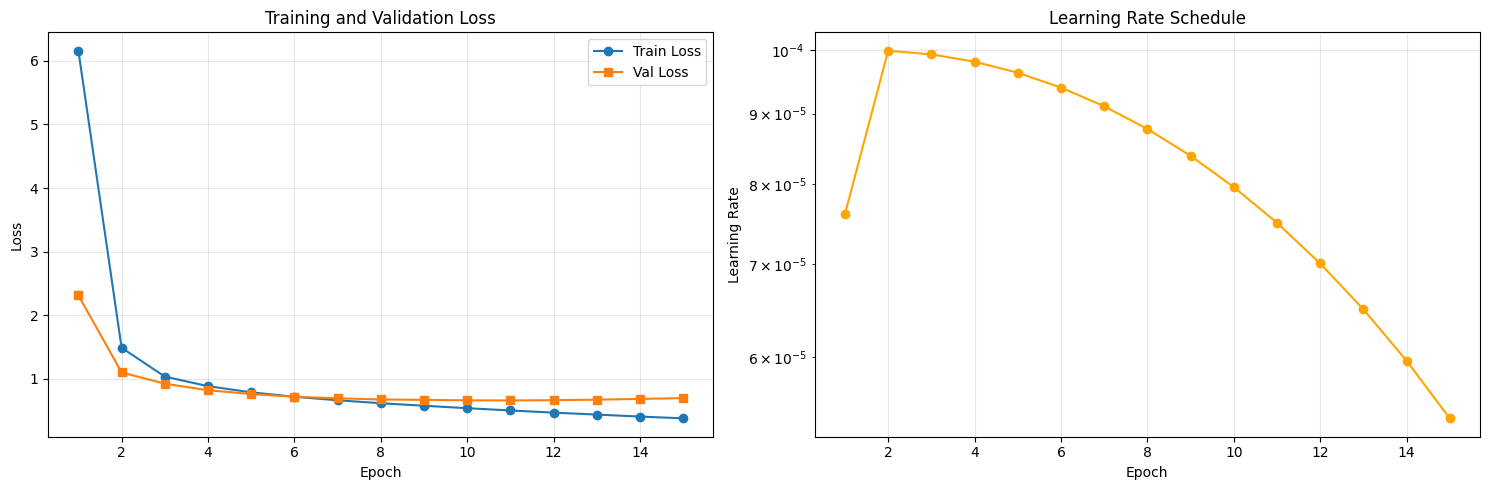

✅ Training curves saved to /content/checkpoints/training_curves.png


In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
axes[0].plot(history['epoch'], history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['epoch'], history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Learning rate
axes[1].plot(history['epoch'], history['learning_rate'], marker='o', color='orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Learning Rate')
axes[1].set_title('Learning Rate Schedule')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{CHECKPOINT_DIR}/training_curves.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Training curves saved to {CHECKPOINT_DIR}/training_curves.png")

## Step 10: Load Best Model and Test

In [12]:
# Load best checkpoint
print("\n📂 Loading best model...")
checkpoint = torch.load(f"{CHECKPOINT_DIR}/best_model.pt", weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ Best model loaded (val_loss: {checkpoint['val_loss']:.4f})")
print(f"   Trained for {checkpoint['epoch']+1} epochs")

# Test on various problems
test_problems = [
    "Problem: Solve for x: 3x + 7 = 22\n\nSolution:",
    "Problem: What is the square root of 144?\n\nSolution:",
    "Problem: If f(x) = 2x + 3, find f(5)\n\nSolution:",
    "Problem: Calculate 15 × 12\n\nSolution:",
    "Problem: Find the area of a circle with radius 5\n\nSolution:"
]

print(f"\n{'='*70}")
print("🧪 FINAL MODEL TESTING")
print(f"{'='*70}\n")

for i, problem in enumerate(test_problems):
    print(f"\n{'─'*70}")
    print(f"Test {i+1}: {problem.split('Solution:')[0].strip()}")
    print(f"{'─'*70}")

    output = generate_sample(model, tokenizer, problem, max_length=256)

    # Extract just the solution part
    if "Solution:" in output:
        solution = output.split("Solution:")[1].strip()
        print(solution[:400])  # Print first 400 chars
    else:
        print(output[:400])
    print()

print(f"{'='*70}")
print("✅ Testing complete!")
print(f"{'='*70}")


📂 Loading best model...
✅ Best model loaded (val_loss: 0.6595)
   Trained for 11 epochs

🧪 FINAL MODEL TESTING


──────────────────────────────────────────────────────────────────────
Test 1: Problem: Solve for x: 3x + 7 = 22
──────────────────────────────────────────────────────────────────────
$x=22$ $x=2$ and $x=2$. Find the solution to the solutions $x=-2$. Step 1: Solution [y=-2\Rightarrow2x=2left(\frac{2}{2}left(-\frac{2}{2}right)=\frac{2}{2}=\boxed{2}.] 2


──────────────────────────────────────────────────────────────────────
Test 2: Problem: What is the square root of 144?
──────────────────────────────────────────────────────────────────────
$144=2^2\cdot5$. What is the equation of this solution? Step 1: Solution We simply note that $144=2^2\cdot5$, so $\sqrt{5}=\sqrt{4\cdot5}=1$. Thus, the side lengths of the right triangle has length $\boxed{1}$. 1


──────────────────────────────────────────────────────────────────────
Test 3: Problem: If f(x) = 2x + 3, find f(5)
────────

## Step 11: Interactive Demo - Try Your Own Problems!

In [13]:
def solve_math_problem(problem_text):
    """Solve a math problem using the trained model"""
    prompt = f"Problem: {problem_text}\n\nSolution:"
    output = generate_sample(model, tokenizer, prompt, max_length=400)

    # Extract solution
    if "Solution:" in output:
        solution = output.split("Solution:")[1]
        # Try to extract answer
        if "<answer>" in solution and "</answer>" in solution:
            answer = solution.split("<answer>")[1].split("</answer>")[0].strip()
            return solution, answer
        return solution, None
    return output, None

print("\n🎯 Interactive Math Problem Solver")
print("="*70)
print("Enter your math problem below (or press Enter to skip):\n")

# Example usage (you can modify this)
custom_problem = "Find the value of x if 5x - 8 = 17"

if custom_problem:
    print(f"Problem: {custom_problem}\n")
    solution, answer = solve_math_problem(custom_problem)
    print("Solution:")
    print("-" * 70)
    print(solution[:500])
    if answer:
        print(f"\nFinal Answer: {answer}")
    print("-" * 70)
else:
    print("(No custom problem provided, skipping interactive demo)")

print("\n✅ Demo complete! Modify the 'custom_problem' variable above to try different problems.")


🎯 Interactive Math Problem Solver
Enter your math problem below (or press Enter to skip):

Problem: Find the value of x if 5x - 8 = 17

Solution:
----------------------------------------------------------------------
 $x = 17 + 8 + 1 = 11$. Step 1: Solution Since both sides are positive, the solutions are $-1 = -2$ and $-2 = -2$, so the solutions are $\boxed{-2 = -2$. -2
----------------------------------------------------------------------

✅ Demo complete! Modify the 'custom_problem' variable above to try different problems.


## Step 12: Save Final Model Metadata

In [14]:
import json

# Create metadata
metadata = {
    "model_size": MODEL_SIZE,
    "total_parameters": total_params,
    "training_examples": len(train_probs),
    "validation_examples": len(val_probs),
    "best_val_loss": best_val_loss,
    "final_epoch": epoch + 1,
    "hyperparameters": {
        "batch_size": BATCH_SIZE,
        "grad_accum_steps": GRAD_ACCUM_STEPS,
        "learning_rate": LEARNING_RATE,
        "max_length": MAX_LENGTH,
        "warmup_steps": WARMUP_STEPS,
    },
    "model_config": {
        "hidden_size": config.hidden_size,
        "num_layers": config.num_hidden_layers,
        "num_heads": config.num_attention_heads,
        "intermediate_size": config.intermediate_size,
    },
    "dataset": "MATH" if USE_FULL_DATASET else "MATH-500",
    "training_date": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
}

# Save metadata
with open(f"{CHECKPOINT_DIR}/model_metadata.json", 'w') as f:
    json.dump(metadata, f, indent=2)

print("\n📊 Model Metadata:")
print(json.dumps(metadata, indent=2))
print(f"\n✅ Metadata saved to {CHECKPOINT_DIR}/model_metadata.json")


📊 Model Metadata:
{
  "model_size": "small",
  "total_parameters": 85074432,
  "training_examples": 10625,
  "validation_examples": 1250,
  "best_val_loss": 0.6595187485218048,
  "final_epoch": 15,
  "hyperparameters": {
    "batch_size": 8,
    "grad_accum_steps": 4,
    "learning_rate": 0.0001,
    "max_length": 1024,
    "warmup_steps": 200
  },
  "model_config": {
    "hidden_size": 512,
    "num_layers": 8,
    "num_heads": 8,
    "intermediate_size": 2048
  },
  "dataset": "MATH",
  "training_date": "2025-12-19 17:08:51"
}

✅ Metadata saved to /content/checkpoints/model_metadata.json


## 🎉 Training Complete!

### What's Saved:
- ✅ `best_model.pt` - Best performing model checkpoint
- ✅ `checkpoint_epoch_*.pt` - Periodic checkpoints
- ✅ `training_curves.png` - Loss and LR visualization
- ✅ `model_metadata.json` - Complete training information

### Next Steps:
1. **Download the model**: From the Files panel (left sidebar)
2. **Use locally**: Load the checkpoint in your local environment
3. **Evaluate**: Test on the MATH test set for proper evaluation
4. **Fine-tune**: Continue training with more data or adjust hyperparameters

### Expected Results:
- With **7,500 examples**: Model should show basic mathematical reasoning
- **Validation loss < 1.0**: Good sign of learning
- **Coherent outputs**: Should generate valid mathematical steps
- **Simple problems**: Should solve basic algebra correctly

### If Results are Poor:
- ✅ Try training for more epochs
- ✅ Use a smaller model ("tiny" size)
- ✅ Lower learning rate (5e-5)
- ✅ Add more data augmentation

---

**Need help?** Check the repository issues or documentation!